## Overview

In this section, we will take a single Sentinel-2 L1C scene downloaded from the [Copernicus Browser](https://dataspace.copernicus.eu/) and learn how to read it using XArray, visualize it and compute spectral indices.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [38]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install rioxarray
  !pip install xarray-spatial


In [39]:
import os
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import zipfile
import geopandas as gpd
import xrspatial.multispectral as ms


In [5]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [31]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

s2_scene = 'S2A_MSIL1C_20230212T050931_N0509_R019_T43PGQ_20230212T065641.SAFE.zip'
data_url = 'https://storage.googleapis.com/spatialthoughts-public-data/'

download(data_url + 's2/' + s2_scene)

aoi = 'bangalore.geojson'
download(data_url + aoi)


Downloaded data/bangalore.geojson


## Data Pre-Processing

We first unzip the zip archive and create a XArray Dataset from the individual band images.



In [7]:
s2_filepath = os.path.join(data_folder, s2_scene)

with zipfile.ZipFile(s2_filepath) as zf:
  zf.extractall(data_folder)

Sentinel-2 images come as individual JPEG2000 rasters for each band. The image files are located in the `GRANULE/{SCENE_ID}/IMG_DATA/` subfolder. We find the files and read them using `rioxarray`.

In [24]:
import glob
s2_folder = s2_filepath[:-4]

bands = []

for filepath in glob.glob(os.path.join(s2_folder, 'GRANULE', '*', 'IMG_DATA', '*B*.jp2')):
  band = rxr.open_rasterio(filepath, chunks={'x':2048, 'y':2048})
  filename = os.path.basename(filepath)
  # Extract the part of the filename containing band name such as 'B01'
  name = os.path.splitext(filename)[0].split('_')[-1]
  band.name = name
  band = band.assign_coords(band=[name])
  bands.append(band)

scene = xr.concat(bands, dim='band')
scene.name = 'S2'

In [27]:
scene.rio.crs

CRS.from_epsg(32643)

In [33]:
aoi_path = os.path.join(data_folder, aoi)
aoi_gdf = gpd.read_file(aoi_path)
geometry = aoi_gdf.to_crs(scene.rio.crs).geometry
geometry

0    POLYGON ((776465.021 1423757.252, 776566.996 1...
Name: geometry, dtype: geometry

In [34]:
clipped = scene.rio.clip(geometry)
clipped

<xarray.DataArray 'S2' (band: 13, y: 5140, x: 5265)>
dask.array<getitem, shape=(13, 5140, 5265), dtype=float32, chunksize=(1, 2756, 3025), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 7.67e+05 7.67e+05 7.67e+05 ... 8.02e+05 8.02e+05
  * y            (y) float64 1.42e+06 1.42e+06 1.42e+06 ... 1.454e+06 1.454e+06
  * band         (band) <U3 'B11' 'B06' 'B07' 'B05' ... 'B12' 'B09' 'B8A' 'B03'
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

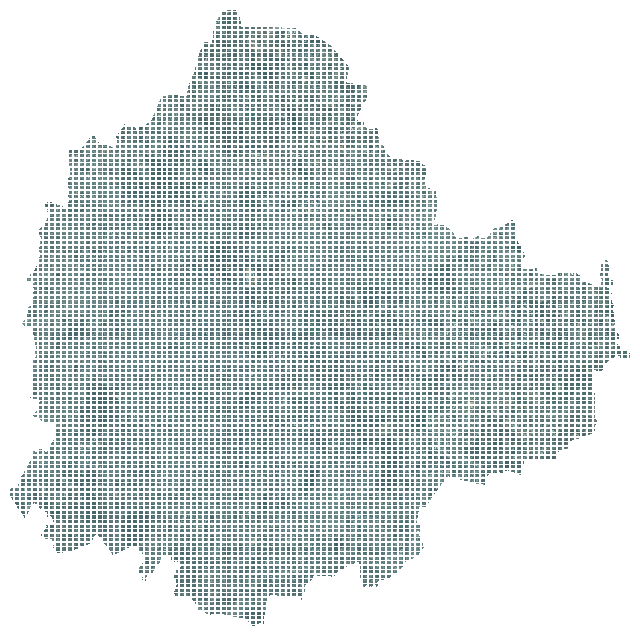

In [41]:
image = ms.true_color(*clipped.sel(band=['B04', 'B03', 'B02']))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8,8)
image.plot.imshow(ax=ax)
ax.set_axis_off()
plt.show()

In [ ]:
clipped.rio.to_raster('output.tif')